In [2]:
# 2.1
# Minsky 与 Papert 指出：感知机因为是线性模型，所以不能表示复杂的函数，如异或 (XOR)。验证感知机为什么不能表示异或。

   x1  x2  y
0   0   0 -1
1   1   0  1
2   0   1  1
3   1   1 -1


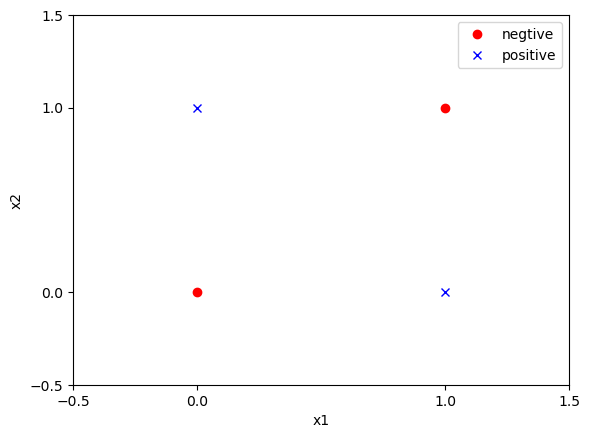

In [3]:
# 2.1.1
# 使用图例法证明异或问题是线性不可分的
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 构建矩阵
x1 = np.array([0, 1, 0, 1])
x2 = np.array([0, 0, 1, 1])
y = np.array([-1, 1, 1, -1])
# 注意这种矩阵列合并的方式，要把合并的元素放在一个list中
data = np.c_[x1, x2, y]
df = pd.DataFrame(data, columns = ['x1', 'x2', 'y'])
print(df)

# 画图
# 设置坐标轴
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.xticks([-0.5, 0, 1, 1.5]) # 这是在设置坐标轴刻度，可以发现要传入的参数是一个list
plt.yticks([-0.5, 0, 1, 1.5])
plt.xlabel('x1')
plt.ylabel('x2')
# 获得正负分类点
negtive = df.loc[df['y'] == -1]
positive = df.loc[df['y'] == 1]
# 在图里面画出来
plt.plot(negtive['x1'], negtive['x2'], 'ro') # 第三个参数表示要画什么样的图
plt.plot(positive['x1'], positive['x2'], 'bx')
# 标上图例
plt.legend(['negtive', 'positive'])


# 这样通过画出训练集样本点的图，可以发现这些样本是完全找不到一个超平面来完全分开的，所以证明，异或问题是不能用感知机来处理的

In [4]:
# 2.1.2
# 使用sklearn的Perceptron类构建感知机模型，从模型的参数上观察，感知机模型无法表示异或
from sklearn.linear_model import Perceptron
import numpy as np

# 构建训练集
x_train = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = np.array([-1, 1, 1, -1])

# train model
perceptron_model = Perceptron()
perceptron_model.fit(x_train, y) # 这个训练方式还是很符合直觉的

# 输出训练结果
print('W_hat', perceptron_model.coef_[0], 'b_hat', perceptron_model.intercept_[0])


# 可以发现，训练出来的模型参数全部是0，显然这模型是没训练出来

W_hat [0. 0.] b_hat 0.0


In [5]:
# 2.2
# 模仿例题 2.1，构建从训练数据求解感知机模型的例子。
# 其实就是仿照上面sklearn中的Perceptron，自己手动写一个出来

In [56]:
# 2.2.1
import numpy as np
import matplotlib.pyplot as plt


class Perceptron:
    def __init__(self, x, y, lr = 0.01, plot = True):
        """
        初始化感知机
        X，Y：训练集
        lr：学习步长
        plot：是否绘图以及显示迭代情况
        """
        self.x = x
        self.y = y
        self.lr = lr
        self.plot = plot
        if plot:
            self.__model_plot = self._ModelPlot(self.x, self.y)
            self.__model_plot.open_in()
        
    def fit_model(self):
        # 初始化w/b两个参数
        weight = np.zeros(self.x.shape[1]) # 保持与x的维数一致
        b = 0
        # 训练次数
        train_counts = 0
        # 是否存在误分类
        mistake = True
        while mistake:
            # 要设置回不存在误分类
            mistake = False
            # 从训练集中取出数据看是不是误分类点
            for index in range(self.x.shape[0]): # 这里就是代表训练集数据点的个数了
                if self.plot:
                    self.__model_plot.plot(weight, b, train_counts)
                # 损失函数
                loss = self.y[index] * (weight @ self.x[index] + b) # 注意这里，点乘用@
                if loss <= 0:
                    # 自然，我们需要更新weight和b
                    weight += self.lr * self.x[index] * self.y[index]
                    b += self.lr * self.y[index]
                    train_counts += 1
                    print('Epoch{},weight={},b={},formula:{}'.format(train_counts, weight, b, self.__model_plot.formula(weight, b)))
                    mistake = True
                    
        if self.plot:
            self.__model_plot.close()
        return weight, b
        
    class _ModelPlot:
        def __init__(self, x, y):
            self.x = x
            self.y = y
            
        @staticmethod
        def open_in():
            # 打开交互模式，可以展示动态的交互图
            plt.ion()
            
        @staticmethod
        def close():
            # 关闭交互模式，并且展示最终的图
            plt.ioff()
            plt.show()
                
        def plot(self, weight, b, epoch):
            plt.cla() # 清屏，我们这里要的只是迭代到最优的一个超平面
            # 设置xy轴的范围，注意这个技巧
            plt.xlim(0, np.max(self.x.T[0] + 1))
            plt.ylim(0, np.max(self.x.T[1] + 1))
            # 画出散点图，添加图示
            scatter = plt.scatter(self.x.T[0], self.x.T[1], c = self.y)
            plt.legend(*scatter.legend_elements())
            # 上面的*，是表示可迭代对象的解包操作，因为我们生成的scatter其实是一个可迭代对象，通过*就可以很优雅的把其中的信息解压出来
            # 这个if的意思就是如果没有迭代出来，全是0
            if True in list(weight == 0):
                plt.plot(0, 0)
            else:
                # 超平面的两个端点
                x1 = -b / weight[0]
                x2 = -b / weight[1]
                plt.plot([x1, 0], [0, x2])
                # 把公式也加上去
                text = self.formula(weight, b)
                plt.text(0.3, x2 - 0.2, text) # 这个函数用法很简单，就是单纯的横坐标纵坐标和内容
                    
        @staticmethod        
        def formula(weight, b):
            text = 'x1' if weight[0] == 1 else '%d*x1' % weight[0]
            text += '+x2' if weight[1] == 1 else ('+%d*x2' % weight[1] if weight[1] > 0 else '-%d*x2' % -weight[1])
            text += '=0' if b == 0 else ('+%d=0' % b if b > 0 else '-%d=0' % -b)
            return text

Epoch1,weight=[3. 3.],b=1,formula:3*x1+3*x2+1=0
Epoch2,weight=[2. 2.],b=0,formula:2*x1+2*x2=0
Epoch3,weight=[1. 1.],b=-1,formula:x1+x2-1=0
Epoch4,weight=[0. 0.],b=-2,formula:0*x1-0*x2-2=0
Epoch5,weight=[3. 3.],b=-1,formula:3*x1+3*x2-1=0
Epoch6,weight=[2. 2.],b=-2,formula:2*x1+2*x2-2=0
Epoch7,weight=[1. 1.],b=-3,formula:x1+x2-3=0


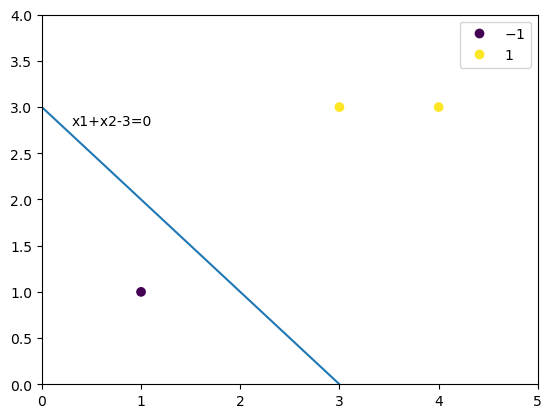

In [57]:
X = np.array([[3, 3], [4, 3], [1, 1]])
Y = np.array([1, 1, -1])
model = Perceptron(X, Y, lr = 1)
weight, b = model.fit_model()